# XAI Laboratory 01 - Tabular Methods

For this practice, you will need the following dataset:

- **fifa**: regression dataset containing FIFA players data:
    - short_name: name of the player
    - nationality
    - overall: overall score of the player (potential output)
    - potential: potential score of the player (potential output)
    - wage_eur: contract cancellation fine of the player (potential output)
    - value_eur: value in euros of the player (potential output)
    - age: age of the player in years
    - height_cm: height of the player in cm
    - weight_kg: weight of the player in kg
    - attacking_skills: several variables related to attacking
    - defending_skills: several variables related to defending
    - goalkeeping_skills: several variables related to goalkeeping

Use what you have learned from the `tabular_explanation.ipynb` notebook to complete the questions.

In [1]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# XAI
import shap
import lime
from alepython import ale_plot # You might need to install from source: pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

np.random.seed(2025)

c:\Users\Javier\OneDrive - Universidad Pontificia Comillas\Escritorio\ICAI\2025-26\Ética y XAI\Explicabilidad\Prácticas\XAI\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Load file --------------------------------------------
df = pd.read_csv('../data/fifa.csv')
df.head()

,short_name,nationality,overall,potential,wage_eur,value_eur,age,height_cm,weight_kg,attacking_crossing,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,L. Messi,Argentina,94,94,565000,95500000,32,170,72,88,...,75,96,33,37,26,6,11,15,14,8
1,Cristiano Ronaldo,Portugal,93,93,405000,58500000,34,187,83,84,...,85,95,28,32,24,7,11,15,14,11
2,Neymar Jr,Brazil,92,92,290000,105500000,27,175,68,87,...,90,94,27,26,29,9,9,15,15,11
3,J. Oblak,Slovenia,91,93,125000,77500000,26,188,87,13,...,11,68,27,12,18,87,92,78,90,89
4,E. Hazard,Belgium,91,91,470000,90000000,28,175,74,81,...,88,91,34,27,22,11,12,6,8,8


In [3]:
X = df.drop(["short_name", "nationality", "overall", "potential", "value_eur", "wage_eur"], axis = 1)
y = df['value_eur']

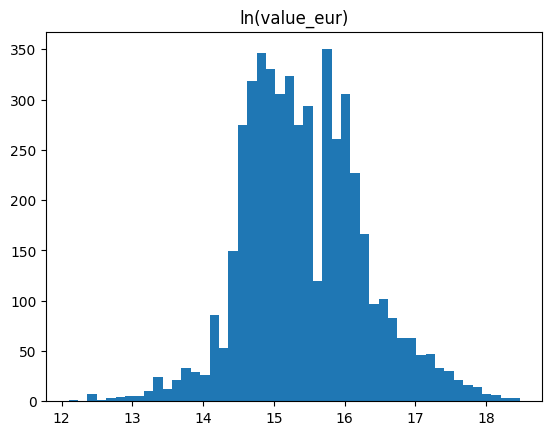

In [4]:
# Change scale of output variable
ylog = np.log(y)

plt.hist(ylog, bins='auto')
plt.title("ln(value_eur)")
plt.show()

In [5]:
X_train, X_test, ylog_train, ylog_test, y_train, y_test = train_test_split(X, ylog, y, test_size=0.25, random_state=42)

In [6]:
# Train XGBoost model, may take a few minutes
model = XGBRegressor()
model.fit(X_train, ylog_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [7]:
def predict_function(model, data):
    """Predict wrapper: original model was trained on log-output; return exp(pred) to recover original scale."""
    return np.exp(model.predict(data))

---
Ex 1. Ensure your model is not overfitted

In [8]:
# Ensure our model is not overfitted
train_score = model.score(X_train, ylog_train)
test_score = model.score(X_test, ylog_test)
print(f"Train R2: {train_score:.3f} - Test R2: {test_score:.3f}")

Train R2: 0.997 - Test R2: 0.926


Como podemos observar, nuestro modelo tiene muy buen rendimiento tanto en entrenamiento como en test, lo cual nos indica que no está sobreajustado (es capaz de generalizar bien a datos no vistos).

---
Ex 2. Obtain and plot variable importance measures using the following variable groups

In [9]:
variable_groups = {
    'age': ['age'],
    'body': ['height_cm', 'weight_kg'],
    'attacking': ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys'],
    'skill': ['skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control'],
    'movement': ['movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance'],
    'power': ['power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots'],
    'mentality': ['mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties',
        'mentality_composure'],
    'defending': ['defending_marking', 'defending_standing_tackle','defending_sliding_tackle'],
    'goalkeeping' : ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']
}

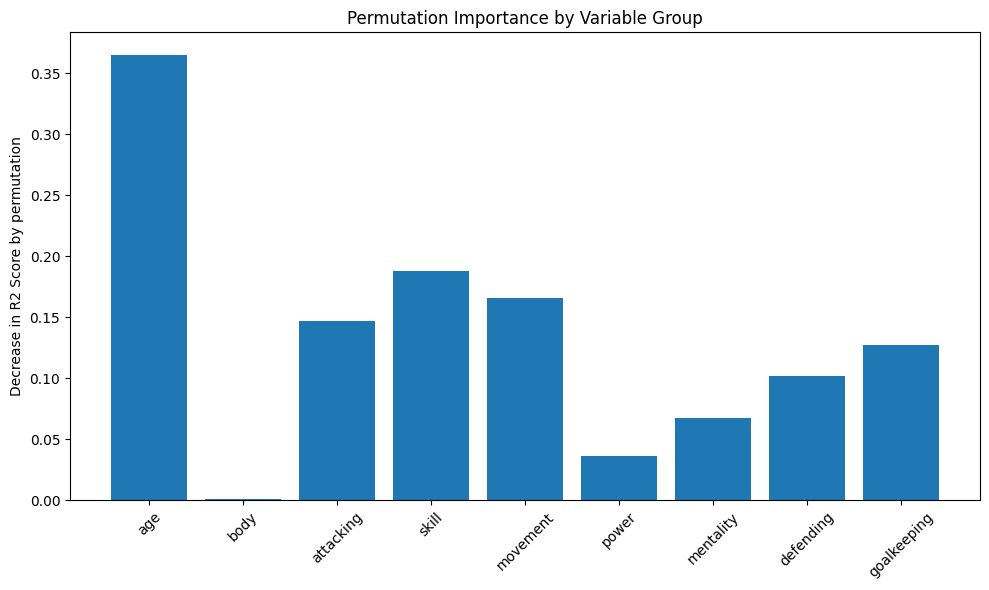

In [10]:
group_scores = {}
n_repeats = 30

for group, features in variable_groups.items():
    X_test_permuted = X_test.copy()
    for f in features:
        X_test_permuted[f] = np.random.permutation(X_test_permuted[f].values)
    score = model.score(X_test_permuted, ylog_test)
    group_scores[group] = score

# Plot importance
base_score = model.score(X_test, ylog_test)
importances = {group: base_score - score for group, score in group_scores.items()}

plt.figure(figsize=(10,6))
plt.bar(importances.keys(), importances.values())
plt.title("Permutation Importance by Variable Group")
plt.ylabel("Decrease in R2 Score by permutation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Análisis: La variable más importante para predecir el overall de un jugador es su edad (age), seguida del conjunto de habilidades (skill). Esto tiene sentido, ya que la edad suele ser un factor determinante en el rendimiento de un jugador, y la habilidad es una medida directa de su capacidad en el campo. Otras variables como el movimiento (movement) y las habilidades ofensivas (attacking) también son relevantes. Algo curioso es que nuestro modelo no ha considerado tan importante las variables corporales (height_cm y weight_kg), lo cual puede ser debido a que en el dataset hay jugadores de diferentes posiciones y estilos de juego, donde la altura y el peso pueden no ser tan determinantes.

---
Ex 3. Obtain which is the variable with higher influence in Leo Messi's value. Justify which algorithm you choose

In [11]:
# Obtener el índice de Messi
idx = df[df['short_name'] == 'L. Messi'].index[0]
X_messi = X_test.iloc[[idx]].values.reshape(1, -1)

exp = shap.TreeExplainer(model)
shap_values = exp.shap_values(X_test)
feats = X_test.columns

# Obtener a Messi en el conjunto de test
single_shap = shap_values[idx]
most_important = feats[np.argmax(np.abs(single_shap))]
print(f"La variable más importante para el valor de Messi es: {most_important}")

La variable más importante para el valor de Messi es: attacking_finishing


Como pretendemos analizar el efecto de las variables en la predicción de una instancia en concreto (Leo Messi), usamos SHAP para obtener la importancia local.

Viendo que la variable con mayor influencia en la predicción del valor de Leo Messi es 'attacking_finishing', podemos concluir que sus habilidades ofensivas son las que más afectan a su valor en el mercado (lo cual concuerda con nuestra posible intuición, dado que juega como delantero).

---
Ex 4. Explain how perturbating the `height_cm` variable affect the value of Cristiano Ronaldo

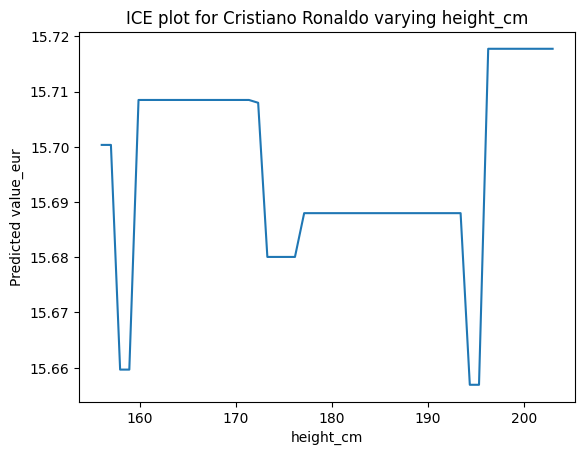

In [15]:
idx_EL_BICHO = df[df['short_name'] == 'Cristiano Ronaldo'].index[0]

feature_name = 'height_cm'
feature_index = X.columns.get_loc(feature_name)

# Grid
feature_values = np.linspace(X[feature_name].min(), X[feature_name].max(), 50)
avg_preds = np.zeros_like(feature_values)

instance = X_test.iloc[[idx_EL_BICHO]].copy()

# ICE Loop
for i, val in enumerate(feature_values):
    instance.iloc[:, feature_index] = val
    prediction = model.predict(instance)
    avg_preds[i] = prediction.item()

# Plot ICE
plt.plot(feature_values, avg_preds)
plt.xlabel(feature_name)
plt.ylabel("Predicted value_eur")
plt.title("ICE plot for Cristiano Ronaldo varying height_cm")
plt.show()

Dado que nuestro objetivo es analizar el efecto de cambiar una variable en concreto (height_cm) para una instancia en concreto (Cristiano Ronaldo), usamos un gráfico *ICE* para observar cómo varía la predicción al modificar dicha variable.

Podemos observar que no parece haber una relación clara entre la altura y el valor de mercado de Cristiano Ronaldo, ya que al aumentar o disminuir su altura, el valor predicho no varía de manera consistente. Esto puede deberse a que la altura no es un factor determinante en el valor de mercado de un jugador como Cristiano Ronaldo, cuya valoración está más influenciada por su rendimiento, habilidades y popularidad.

---
Ex 5. Explain the average effect of the `age` variable on the model predictions. Does it differ greatly along the samples in the dataset? Which should be more affected by perturbating this variable, the goalkeepers or the strikers?

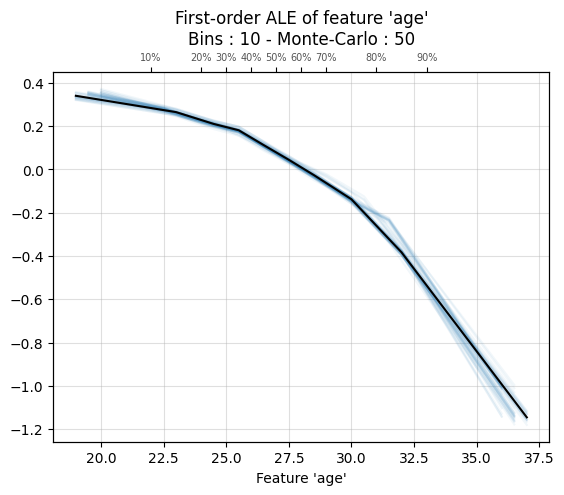

<Axes: title={'center': "First-order ALE of feature 'age'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'age'">

In [17]:
ale_plot(model, X_train, 'age', monte_carlo=True, monte_carlo_ratio=0.5, monte_carlo_rep=50)

Como pretendemos analizar el efecto promedio de una variable en todas las instancias del dataset, debemos escoger un método global. En concreto, como queremos obtener tendencias globales pero segmentables por rol, usamos ALE plots.

Analicemos ahora los resultados. Primero de todo, vemos que en edades tempranas (más o menos hasta los 28 años) el valor predicho aumenta con la edad, tendencia que se invierte a partir de entonces. Por lo tanto, nuestro modelo opina que un jugador, ceteris paribus, alcanza su máximo valor de mercado alrededor de los 28 años, y a partir de ahí su valor disminuye con la edad. Esta tendencia es global a lo largo de todos los roles, con dos matices: Existe un grupo de jugadores cuyo valor parece disminuir más lentamente a partir de los 28 años (observemos el pico de algunas líneas alredededor de los 31 años). Podríamos hacer un análisis más detallado para observar qué roles ocupan este tipo de jugador. Sin embargo, opino que podría tratarse de jugadores con posición portero (goalkeepers), ya que suelen tener carreras más largas y su valor no disminuye tan rápidamente con la edad como el de los jugadores de campo. Asimismo, existe un estrato de jugadores cuyo valor disminuye incluso más drásticamente a partir de los 33 años. Podríamos suponer que estos jugadores son los delanteros (strikers), ya que suelen depender más de sus capacidades físicas, las cuales se ven más afectadas por la edad.

---
Ex 6. Explain the prediction made for Hazard using a local surrogate model (Lime)

In [19]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['value_eur'],
    discretize_continuous=True
)

idx = df[df['short_name'] == 'E. Hazard'].index[0]
exp = explainer.explain_instance(
    X_test.iloc[idx].values,
    model.predict,
    num_features=8
)
exp.show_in_notebook(show_table=True)

NotImplementedError: LIME does not currently support classifier models without probability scores. If this conflicts with your use case, please let us know: https://github.com/datascienceinc/lime/issues/16

>>> Your explanation here